In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels
import scipy
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import scipy.stats
import pylab
import matplotlib as mpl
from scipy.stats.distributions import chi2
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import norm
sns.set()

In [2]:
raw_index_data=pd.read_csv('Index2018.csv')  # Index price data Importation in Raw_index_data variable
df_index=raw_index_data.copy()  # copy to df_index from Raw_index_data
df_index.date=pd.to_datetime(df_index.date,dayfirst=True) # datatype of date column changed to datetime 
df_index.set_index('date',inplace=True) # set date column as index
df_index=df_index.asfreq('b') # setting frequency of data obsevation to business days
df_index.shape #shape checking 

(6277, 4)

In [3]:
df_index.spx.fillna(method='ffill',inplace=True) # front filling of missing values of spx columns
df_index.ftse.fillna(method='bfill',inplace=True) # backfilling of missing values of ftse columns
df_index.dax.fillna(df_index.dax.mean(),inplace=True) # mean value assigned to each missing values of dax columns 
df_index.nikkei.fillna(df_index.nikkei.median(),inplace=True) # median value assigned to each missing value of nikkei

In [4]:
df_market_value=df_index[['ftse']] # Selecting FTSE index for further processing
df_market_value.rename(columns={'ftse':'market_value'},inplace=True) # renaming ftse to market value
traininglen=int(len(df_market_value)*0.8) # Train and test split with ratio of 80:20
testingLen=len(df_market_value)-traininglen
df_market_value_train=df_market_value.iloc[:traininglen,:]
df_market_value_test=df_market_value.iloc[traininglen:,:]

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [5]:
mean=df_market_value_train['market_value'].mean() # calculating mean of ftse market index values from training part of dataset
std=df_market_value_train['market_value'].std() # calculating std from same
wn=np.random.normal(loc=mean,scale=std,size=len(df_market_value_train)) # creating white noice using np.random.uniform()
df_market_value_train['wn']=wn 

C:\Users\adadi\AppData\Local\Temp/ipykernel_17672/2511373873.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_market_value_train['wn']=wn


In [6]:
rw=pd.read_csv('RandWalk.csv') # adding new column for random walk in training dataframe  
rw.date=pd.to_datetime(rw.date,dayfirst=True)
rw.set_index('date',inplace=True)
df_market_value_train=pd.merge(left=df_market_value_train,right=rw,left_index=True, right_index=True)
df_market_value_train.rename(columns={'price':'rw'},inplace=True) # renaming the randomwalk value column

In [7]:
df_market_value_train.head()

,market_value,wn,rw
date,,,
1994-01-07,3445.98,6729.852346,1122.139662
1994-01-10,3440.58,6595.439990,1080.347860
1994-01-11,3413.77,2709.633621,1082.095245
1994-01-12,3372.02,3986.095762,1083.639265
1994-01-13,3360.01,4820.271204,1067.146255


## Moving Average Modeling.

####  ***what it is the requirement?***
* The main reason to use moving avg to deal with unpredictable shocks in time series data.
* For example lets say that the model trained with stationary data but due to unpredictable reason there is a spike occur both positive or negative direction in index price. So in this case there would huge gap between prediction and actual index price. and Auto regression model this gap will increase with time. But one thing we can observe from this phenomenon that avg price of the whole series must have shifted either upward direction or downward direction depend upon market sentiments.
* So after this shift we can expect that index series will maintains it's stationarity after that point of spike.
* That shift in avg price must be realted to the residual that obtained from that period in which that spick occuared.
* So we model that average shifting of price by residual obtained in given time period.
* So this is how moving average concept comes into the picture.
* Since this shifting of avg price can be occuared frequently in market. So we will create moving average model such that it will adjust itself with residual obtained in last period.
* IF residual obtained is positive: it means if (actual - prediction)>0 it means that residual would be positive and series will shift in upward direction and some factor of residual will be added to output that would have gotten usually from model.
* Similarly if (actual-prediction)<0: then it means that residual would be negative. it also means that price index has shifted downward. So residual obtained in last certain period multplied by some constant factor will be reduced from output that would have gotten usually, if moving average were not considered.

#### ***Solution of the problem in mathmatical form***
X(t) = C1 * Epi_(t-1) + C2 * Epi_(t-2) + .....CN * Epi_(t-n)
- X(t): current value of index price
- Ci: Constant factor For lag i.
- Epi_(t-i): residual obtained in ith period. 

##### ***Properties***
- This model perform well in random walk dataseries cause it adjust itself with error that it has obtained perviously.
- It alows prediction to move in the direction in which market sentiment want to move.
- Use full for non stationary data cause it prevent model diverge away from actual values.
- absolute value of Constant factor Ci should be less than 1.
- During modeling of AR model pacf is used but for MA modeling ACf is used.
- Total accumulate effect of residual error in past certain period will accommodate the shock.

## Moving Average Modeling development on FTSE Return 

* Since this moving average model does not perform well independently on non-stationary data so we will use return column for modeling.
* this return column is calculated by following formula.
* return(t)= [X (t) - X ( t-1 )] / X ( t-1 )

In [8]:
df_market_value_train['return']=df_market_value_train['market_value'].pct_change(1).mul(100)
df_market_value_train=df_market_value_train[1:]
df_market_value_train.head()

,market_value,wn,rw,return
date,,,,
1994-01-10,3440.58,6595.439990,1080.347860,-0.156704
1994-01-11,3413.77,2709.633621,1082.095245,-0.779229
1994-01-12,3372.02,3986.095762,1083.639265,-1.222988
1994-01-13,3360.01,4820.271204,1067.146255,-0.356166
1994-01-14,3400.56,4149.963130,1080.129720,1.206842


#### ***aduller test***

In [9]:
adfuller(df_market_value_train['return'])

(-12.786930957227383,
 7.213255047800936e-24,
 32,
 4987,
 {'1%': -3.431661944885779,
  '5%': -2.8621197374408225,
  '10%': -2.5670785949998973},
 15700.846444346233)

#### ***Acf plot***

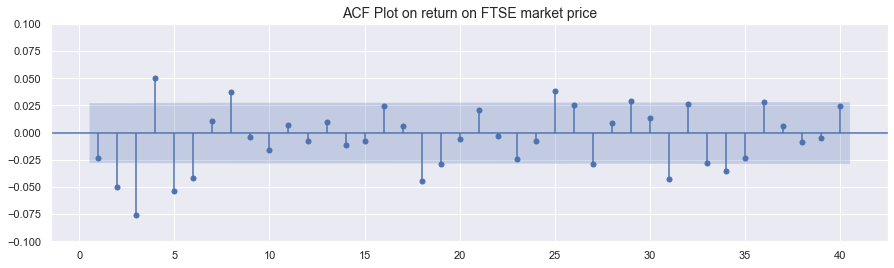

In [10]:
mpl.rc("figure", figsize=(15,4))
sgt.plot_acf(df_market_value_train['return'],lags=40,zero=False)
plt.title('ACF Plot on return on FTSE market price',size=14)
plt.ylim((-0.1, 0.1))
plt.show()

### ***MA1***

In [11]:
model_ma1=ARIMA(df_market_value_train['return'],order=(0,0,1),freq='B')
result_ma1=model_ma1.fit()
print(result_ma1.summary())


C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -7929.601
Date:                Thu, 24 Oct 2024   AIC                          15865.203
Time:                        11:52:55   BIC                          15884.766
Sample:                    01-10-1994   HQIC                         15872.058
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.146      0.252      -0.013       0.051
ma.L1         -0.0257      0.009     -3.013      0.003      -0.042      -0.009
sigma2         1.3789      0.014     99.997      0.0

In [12]:
def LLR_test(Model_a_res,Model_b_res,df=1):
    La=Model_a_res.llf
    Lb=Model_b_res.llf
    Q=2*(Lb-La)
    P=chi2.sf(Q,df)
    return P

## ***MA2***

In [13]:
model_ma2=ARIMA(df_market_value_train['return'],order=(0,0,2),freq='B')
result_ma2=model_ma2.fit()
print(result_ma2.summary())
print('LLR Test',LLR_test(result_ma1,result_ma2))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood               -7922.730
Date:                Thu, 24 Oct 2024   AIC                          15853.461
Time:                        11:52:57   BIC                          15879.545
Sample:                    01-10-1994   HQIC                         15862.601
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.016      1.205      0.228      -0.012       0.049
ma.L1         -0.0324      0.009     -3.732      0.000      -0.049      -0.015
ma.L2         -0.0508      0.008     -6.493      0.0

## ***MA3***

In [14]:
model_ma3=ARIMA(df_market_value_train['return'],order=(0,0,3),freq='B')
result_ma3=model_ma3.fit()
print(result_ma3.summary())
print('LLR Test',LLR_test(result_ma2,result_ma3))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -7905.463
Date:                Thu, 24 Oct 2024   AIC                          15820.927
Time:                        11:52:58   BIC                          15853.533
Sample:                    01-10-1994   HQIC                         15832.352
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.292      0.196      -0.010       0.048
ma.L1         -0.0208      0.009     -2.399      0.016      -0.038      -0.004
ma.L2         -0.0561      0.008     -7.085      0.0

 ## ***MA4***

In [15]:
model_ma4=ARIMA(df_market_value_train['return'],order=(0,0,4),freq='B')
result_ma4=model_ma4.fit()
print(result_ma4.summary())
print('LLR Test',LLR_test(result_ma3,result_ma4))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 4)   Log Likelihood               -7900.498
Date:                Thu, 24 Oct 2024   AIC                          15812.996
Time:                        11:53:00   BIC                          15852.123
Sample:                    01-10-1994   HQIC                         15826.707
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.236      0.217      -0.011       0.049
ma.L1         -0.0208      0.009     -2.290      0.022      -0.039      -0.003
ma.L2         -0.0556      0.008     -6.898      0.0

## ***MA5***

In [16]:
model_ma5=ARIMA(df_market_value_train['return'],order=(0,0,5),freq='B')
result_ma5=model_ma5.fit()
print(result_ma5.summary())
print('LLR Test',LLR_test(result_ma4,result_ma5))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 5)   Log Likelihood               -7894.562
Date:                Thu, 24 Oct 2024   AIC                          15803.124
Time:                        11:53:02   BIC                          15848.773
Sample:                    01-10-1994   HQIC                         15819.120
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.282      0.200      -0.010       0.048
ma.L1         -0.0265      0.009     -2.874      0.004      -0.045      -0.008
ma.L2         -0.0504      0.008     -6.228      0.0

## ***MA6***

In [17]:
model_ma6=ARIMA(df_market_value_train['return'],order=(0,0,6),freq='B')
result_ma6=model_ma6.fit()
print(result_ma6.summary())
print('LLR Test',LLR_test(result_ma5,result_ma6))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 6)   Log Likelihood               -7890.975
Date:                Thu, 24 Oct 2024   AIC                          15797.950
Time:                        11:53:04   BIC                          15850.119
Sample:                    01-10-1994   HQIC                         15816.231
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.014      1.317      0.188      -0.009       0.047
ma.L1         -0.0240      0.009     -2.597      0.009      -0.042      -0.006
ma.L2         -0.0491      0.008     -6.043      0.0

## ***MA7***

In [18]:
model_ma7=ARIMA(df_market_value_train['return'],order=(0,0,7),freq='B')
result_ma7=model_ma7.fit()
print(result_ma7.summary())
print('LLR Test',LLR_test(result_ma6,result_ma7))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 7)   Log Likelihood               -7890.792
Date:                Thu, 24 Oct 2024   AIC                          15799.584
Time:                        11:53:06   BIC                          15858.274
Sample:                    01-10-1994   HQIC                         15820.150
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.302      0.193      -0.010       0.047
ma.L1         -0.0250      0.009     -2.683      0.007      -0.043      -0.007
ma.L2         -0.0493      0.008     -6.061      0.0

## ***MA8***

In [19]:
model_ma8=ARIMA(df_market_value_train['return'],order=(0,0,8),freq='B')
result_ma8=model_ma8.fit()
print(result_ma8.summary())
print('LLR Test',LLR_test(result_ma6,result_ma8,2))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 8)   Log Likelihood               -7887.171
Date:                Thu, 24 Oct 2024   AIC                          15794.342
Time:                        11:53:09   BIC                          15859.554
Sample:                    01-10-1994   HQIC                         15817.193
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.251      0.211      -0.011       0.049
ma.L1         -0.0241      0.009     -2.556      0.011      -0.043      -0.006
ma.L2         -0.0500      0.008     -6.105      0.0

## ***MA9***

In [20]:
model_ma9=ARIMA(df_market_value_train['return'],order=(0,0,9),freq='B')
result_ma9=model_ma9.fit()
print(result_ma9.summary())
print('LLR Test',LLR_test(result_ma8,result_ma9))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                 return   No. Observations:                 5020
Model:                 ARIMA(0, 0, 9)   Log Likelihood               -7886.994
Date:                Thu, 24 Oct 2024   AIC                          15795.988
Time:                        11:53:12   BIC                          15867.721
Sample:                    01-10-1994   HQIC                         15821.124
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0189      0.015      1.255      0.210      -0.011       0.048
ma.L1         -0.0246      0.009     -2.601      0.009      -0.043      -0.006
ma.L2         -0.0498      0.008     -6.066      0.0

#### ***Observation***
- By observing all moving average model with different max lags value it is clear that model MA8 has performed well.
- significance of all coefficient of model MA8 are very good except coefficient at lag 7th.
- It is also evident from acf plot of reuturn time series data that upto model 8 current value has significant correlation except 7th lag values.
### ***Conclusion***
- Moving average model with max lags value 8 has selected for future return prediction of FTSE market index.

## ***Analysis of residual obtained from MA8 model prediction of return on Ftse index price***

In [21]:
df_market_value_train['resid_ret_mv']=result_ar8.resid.values

In [22]:
adfuller(df_market_value_train.resid_ret_mv)

(-70.83980942194609,
 0.0,
 0,
 5019,
 {'1%': -3.4316535759402753,
  '5%': -2.8621160400844468,
  '10%': -2.567076626752987},
 15693.004858473621)

In [23]:
mean,std=df_market_value_train.resid_ret_mv.mean(), df_market_value_train.resid_ret_mv.std()
mean,std

(-5.1735635959538624e-05, 1.1645179499365232)

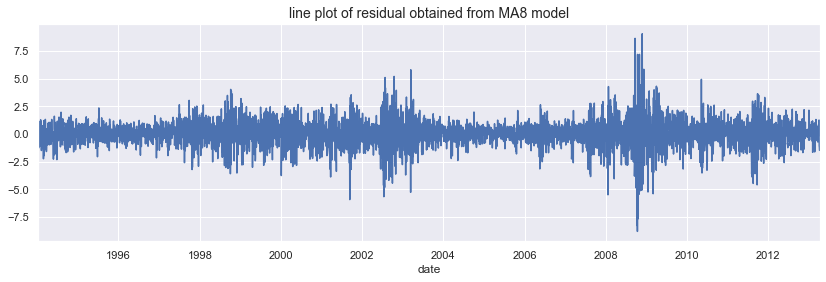

In [24]:
plt.rc('figure',figsize=(14,4))
df_market_value_train.resid_ret_mv.plot()
plt.title('line plot of residual obtained from MA8 model',size=14)
plt.show()

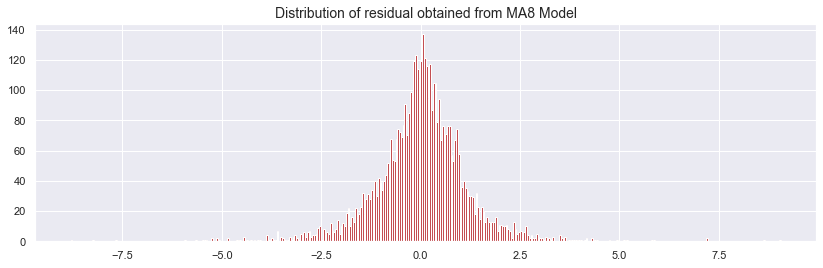

In [25]:
plt.rc('figure',figsize=(14,4))
df_market_value_train.resid_ret_mv.hist(bins=400,color='r')
plt.title('Distribution of residual obtained from MA8 Model',size=14)
plt.show()

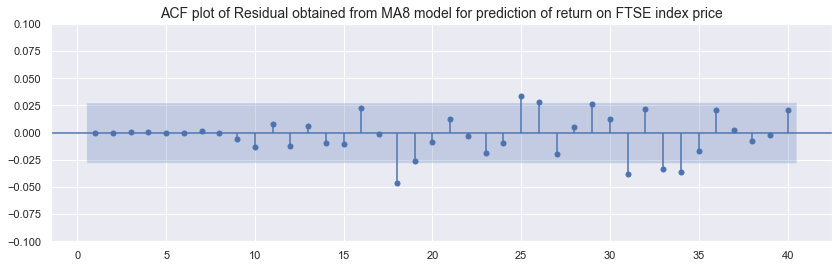

In [26]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(df_market_value_train.resid_ret_mv.values,lags=40,zero=False)
plt.title('ACF plot of Residual obtained from MA8 model for prediction of return on FTSE index price',size=14)
plt.ylim((-0.1,0.1))
plt.show()

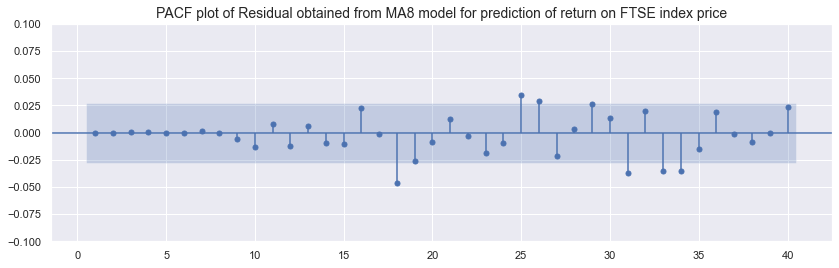

In [27]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(df_market_value_train.resid_ret_mv.values,lags=40,zero=False,method='ols')
plt.title('PACF plot of Residual obtained from MA8 model for prediction of return on FTSE index price',size=14)
plt.ylim((-0.1,0.1))
plt.show()

In [28]:
ci=norm.interval(alpha=0.997,loc=mean,scale=std)
ci

(-3.456035820403844, 3.455932349131911)

#### ***Observation and Conclusion***
- by observing adfuller test we can say that residual are stationary.
- by observing distribution of residual and acf and pacf plot we can say that residual behave like white noice.
- since white noice resembles with normal distribution we can inference about the residual by taking reference of normal distribution.
- mean of the residual are near to zero. more precisely -5.1735635959538624e-05
- std deviation of residual is 1.16451
- confidence interval around mean where 99.7 percent of data lies are inbetween (-3.456035820403844, 3.455932349131911).
- By using refering the confidence interval we can say that 99.7% of time model MA8 will generate error in between -3.45 to +3.45.
- This confidence interval gotten from MA8 model is same as confidence interval gotten from AR6 for prediction of return on FTSE index price.

## ***Moving average modeling on FTSE Index price***

#### ***Adfuller Test***

In [29]:
adfuller(df_market_value_train.market_value)

(-1.893656862412277,
 0.3350509815864389,
 6,
 5013,
 {'1%': -3.431655136974821,
  '5%': -2.8621167297421373,
  '10%': -2.567076993884522},
 54846.470530988365)

<function matplotlib.pyplot.show(close=None, block=None)>

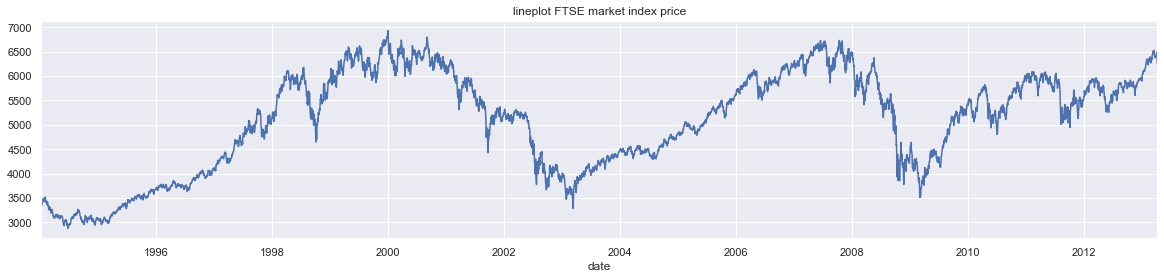

In [34]:
plt.figure(figsize=(20,4))
df_market_value_train.market_value.plot()
plt.title('lineplot FTSE market index price')
plt.show

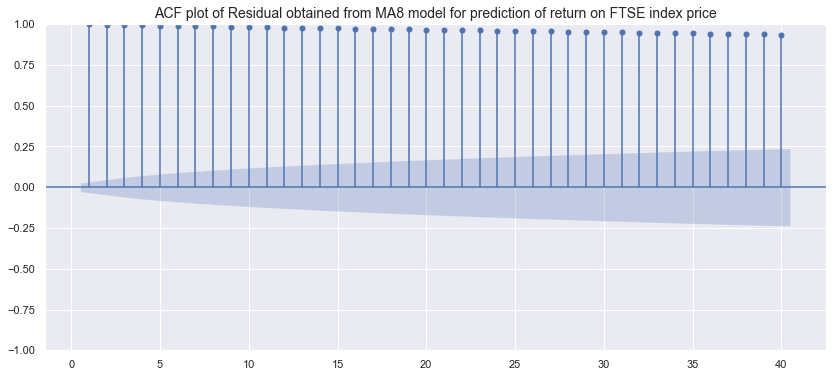

In [32]:
# plt.rc('figure',figsize=())
sgt.plot_acf(df_market_value_train.market_value.values,lags=40,zero=False)
plt.title('ACF plot of Residual obtained from MA8 model for prediction of return on FTSE index price',size=14)
# plt.ylim((-0.1,0.1))
plt.show()

#### ***Observation***
- Adfuller test says that it is not stationary.
- It is also evident form line plot of FTSE market index price values.
- ACF plot says that all the 40  previous values has near to 1 correlation with the current price.
- So we considered all the previous possible lag then our model would be most accurate.
- But since we cant use all previous lag cause it will make the model complecated. So this theoratical consideration of infinite previous lag residual for moving average does not exist.
- Lets try to Model MA with this FTSE market index price.

### ***MA1 On FTSE market index price***

In [38]:
model_ma1=ARIMA(df_market_value_train['market_value'],order=(0,0,1),freq='B')
result_ma1=model_ma1.fit()
print(result_ma1.summary())

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(0, 0, 1)   Log Likelihood              -38620.226
Date:                Thu, 24 Oct 2024   AIC                          77246.452
Time:                        12:35:29   BIC                          77266.016
Sample:                    01-10-1994   HQIC                         77253.308
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5090.0189     15.828    321.590      0.000    5058.997    5121.041
ma.L1          0.9572      0.004    231.560      0.000       0.949       0.965
sigma2      2.815e+05   8153.984     34.527      0.0

#### ***Observation***
- Here we can observe that the coefficient-1 are significant and has near to 1 value.
- so it indicate that model wants to incorporate all the residual obtained in last period.
- It can be also shown that this single lag incorporating moving average can be expresed in term of AR and residual term too.
>proof
- X(t-1) = K + C1 * Epsln(t-2) + Epsln(t-1)
- X(t) = K +  C1 * Epsln(t-1) + Epsln(t)
- Since C1 is near equal to 1 So
- X(t) = K + C1 * ( X(t-1) - K - C1 * Epsln(t-2) ) + Epsln(t)
- X(t) = K + X(t-1) - K + Epsln(t-2) - Epsln(t)    since: C1~1
- X(t) = X(t-1)+ Epsln(t-2) + Epsln(t)
- As we can see this last equation seems like in consist of residual obtained in t-2 lag and value obtained in t-1 lag. So it proves out claim that this prediction of future price can be done incorporating past values and past residuals, given that coefficient obatained in moveing avg model is near equal to 1.
- But we can already tell that coefficient of moving average model for this data is always going to be near equal to 1, since it is evidenet from the ACF plot of the FTSE market index price data.

#### ***Analusis of Residual obtained moving average model for predicting FTSE price index***

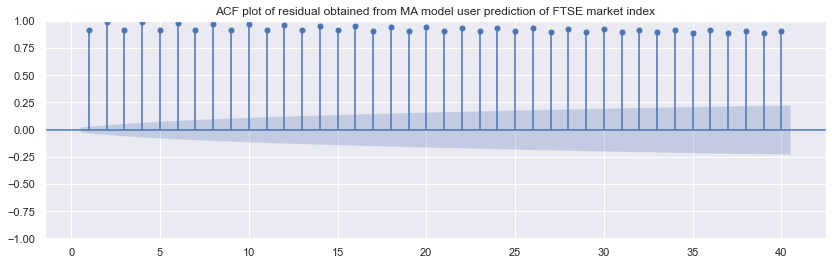

In [43]:
plt.rc('figure',figsize=(14,4))
sgt.plot_acf(result_ma1.resid.values,lags=40,zero=False)
plt.title('ACF plot of residual obtained from MA model user prediction of FTSE market index')
plt.show()

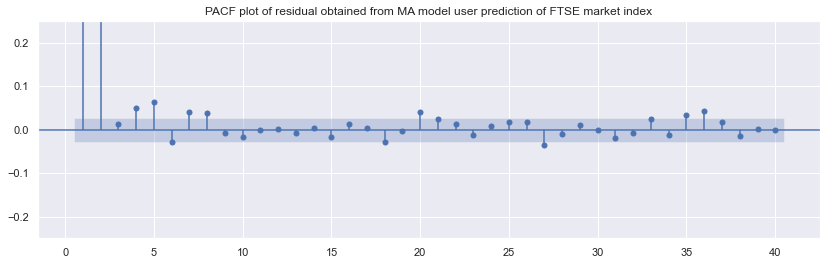

In [45]:
plt.rc('figure',figsize=(14,4))
sgt.plot_pacf(result_ma1.resid.values,lags=40,zero=False,method='ols')
plt.title('PACF plot of residual obtained from MA model user prediction of FTSE market index')
plt.ylim((-0.25,0.25))
plt.show()

In [46]:
adfuller(result_ma1.resid.values)

(-1.934707431954792,
 0.31591385135146033,
 7,
 5012,
 {'1%': -3.431655397510801,
  '5%': -2.862116844845668,
  '10%': -2.567077055158601},
 54848.416132860366)

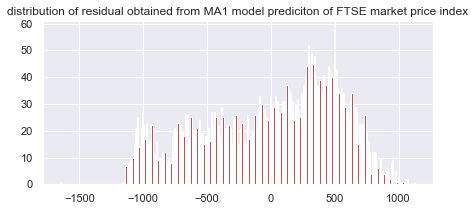

In [49]:
plt.rc('figure',figsize=(7,3))
plt.hist(result_ma1.resid.values,bins=300,color='r')
plt.title('distribution of residual obtained from MA1 model prediciton of FTSE market price index')
plt.show()

#### ***Observation***
- By observing adfuller test of residual it is clear that it is not stationary.
- It is also evident from the distribution plot of the residuals.
- By observing the ACF and PACF plot residuals it is can be said that the model has failed to learn all the correlated pattern exist between lags, since signficant correltion exist between residuals in ACF plot and PACF plot.

#### ***conclusion***
- Since residual are not completely uncorrelated and not stationary at all, So we can conclude that the residual is white noice.
- So we can say that moving avg model failed perform well in instationary data.
- But we have said it before that moving average model perform well in random walk, So How it is possible.
- Moving AVerage perform well in Random Walk because this in random walk the value of current deppend upon last period value and some residual. So in this case even if we model with Moving average model but we have to give refernce/Base value to the model to make the prediction.
- In other word we can say that aggregation of autoregression and moving average will perform well in this kind of scenario.
- The reason this aggregate model perfrom well cause
  1. moving average part will handle unexpected shocks by increaseing or decreasing the prediction value of autoregression part.
  2. for given moving average prediced values the autoregression part will give base point value for moving average model to start with in each time point.
- More about this hybrid model of AR and MA in the next notebook 5.ARMA.....ipynb

In [39]:
model_ma2=ARIMA(df_market_value_train['market_value'],order=(0,0,2),freq='B')
result_ma2=model_ma2.fit()
print(result_ma2.summary())
print('LLR test on MA1 and MA2',LLR_test(result_ma1,result_ma2))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(0, 0, 2)   Log Likelihood              -36008.911
Date:                Thu, 24 Oct 2024   AIC                          72025.823
Time:                        12:36:42   BIC                          72051.908
Sample:                    01-10-1994   HQIC                         72034.963
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5090.0205     16.246    313.305      0.000    5058.178    5121.863
ma.L1          1.6065      0.007    228.908      0.000       1.593       1.620
ma.L2          0.8700      0.007    123.006      0.0

In [40]:
model_ma3=ARIMA(df_market_value_train['market_value'],order=(0,0,3),freq='B')
result_ma3=model_ma3.fit()
print(result_ma3.summary())
print('LLR test on MA2 and MA3',LLR_test(result_ma2,result_ma3))

C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)
C:\Users\adadi\anaconda3\envs\DataScienceEnv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           market_value   No. Observations:                 5020
Model:                 ARIMA(0, 0, 3)   Log Likelihood              -34434.623
Date:                Thu, 24 Oct 2024   AIC                          68879.247
Time:                        12:38:55   BIC                          68911.853
Sample:                    01-10-1994   HQIC                         68890.672
                         - 04-05-2013                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       5090.0241     20.112    253.085      0.000    5050.605    5129.443
ma.L1          1.6638      0.014    120.839      0.000       1.637       1.691
ma.L2          1.6139      0.013    121.848      0.0